In [21]:
import json
import re

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

In [22]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
def create_text_processor(word_index, max_length):
    filters = r'[!"#$%&()*+,\-./:;<=>?@\[\\\]^_`{|}~\t\n]'
    def text_to_sequence(text):
        cleaned = re.sub(filters, ' ', text.lower())
        tokens = [w for w in cleaned.split() if w]
        seq = [word_index.get(w, 0) for w in tokens]
        seq = [i for i in seq if i != 0][:max_length]
        return seq
    return text_to_sequence


def pad_sequence(seq, max_length):
    padded = np.zeros(max_length, dtype=np.int32)
    length = min(len(seq), max_length)
    padded[:length] = seq[:length]
    return padded

In [24]:
def load_samples(data_path):
    samples = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            samples.append(json.loads(line))
    return samples


def data_generator(samples, labels, text_to_sequence, max_length):
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    num_classes = len(labels)
    for sample in samples:
        seq = text_to_sequence(sample.get('sentence', ''))
        xs = pad_sequence(seq, max_length)
        lbl = sample.get('label')
        if lbl not in label_to_index:
            continue
        y = np.zeros(num_classes, dtype=np.float32)
        y[label_to_index[lbl]] = 1.0
        yield xs, y

In [25]:
def create_model(num_classes, vocab_size, max_length, embedding_dim, lstm_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=vocab_size,
                                  output_dim=embedding_dim),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(units=lstm_units)),
        tf.keras.layers.Dropout(rate=0.5),
        tf.keras.layers.Dense(units=num_classes,
                              activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [26]:
MAX_SEQ_LEN = 200
EMBEDDING_DIM = 100
LSTM_UNITS = 64
BATCH_SIZE = 16

In [27]:
data_path = '../data/text_pairs_dataset.jsonl'
vocab_path = '../data/vocab.json'

print('TensorFlow version:', tf.__version__)

with open(vocab_path, 'r', encoding='utf-8') as f:
    tokenizer = json.load(f)
word_index = tokenizer.get('word_index', {})
vocab_size = len(word_index) + 1

labels = ['company overview', 'company services',
            'client review', 'other', 'contact info']

TensorFlow version: 2.19.0


In [28]:
samples = load_samples(data_path)
size = len(samples)
print(f'Loaded {size} samples.')

Loaded 5725 samples.


In [29]:
text_to_sequence = create_text_processor(word_index, MAX_SEQ_LEN)
ds = tf.data.Dataset.from_generator(
    lambda: data_generator(samples, labels, text_to_sequence, MAX_SEQ_LEN),
    output_signature=(
        tf.TensorSpec(shape=(MAX_SEQ_LEN,), dtype=tf.int32),
        tf.TensorSpec(shape=(len(labels),), dtype=tf.float32),
    )
)
ds = ds.shuffle(buffer_size=size)

train_size = int(size * 0.8)
val_size = int(size - train_size)
train_ds = ds.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds.skip(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [30]:
model = create_model(len(labels), vocab_size,
                        MAX_SEQ_LEN, EMBEDDING_DIM, LSTM_UNITS)

In [55]:
history = model.fit(train_ds,
            validation_data=val_ds,
            epochs=10)

Epoch 1/10
    287/Unknown 4s 10ms/step - accuracy: 0.7512 - loss: 0.7049

2025-04-19 11:37:37.058353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:37:37.058383: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:37:37.058390: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318
/home/daniel/Desktop/Coding/thundrmodels/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7513 - loss: 0.7049 - val_accuracy: 0.8107 - val_loss: 0.5555
Epoch 2/10


2025-04-19 11:37:38.106592: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:37:38.106607: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992
2025-04-19 11:37:38.106612: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16728944997438500400
2025-04-19 11:37:38.106614: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 12456980574774171600


286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7914 - loss: 0.6241

2025-04-19 11:37:41.716903: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:37:41.716916: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:37:41.716922: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7914 - loss: 0.6240 - val_accuracy: 0.7844 - val_loss: 0.5898
Epoch 3/10


2025-04-19 11:37:42.805989: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:37:42.806003: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992
2025-04-19 11:37:42.806007: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16728944997438500400
2025-04-19 11:37:42.806010: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 12456980574774171600


283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8142 - loss: 0.5688

2025-04-19 11:37:46.450671: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:37:46.450686: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:37:46.450691: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8142 - loss: 0.5689 - val_accuracy: 0.8580 - val_loss: 0.4788
Epoch 4/10


2025-04-19 11:37:47.546696: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:37:47.546711: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992
2025-04-19 11:37:47.546716: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16728944997438500400


285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8439 - loss: 0.5160

2025-04-19 11:37:51.208176: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:37:51.208190: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:37:51.208196: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8439 - loss: 0.5160 - val_accuracy: 0.8352 - val_loss: 0.4679
Epoch 5/10


2025-04-19 11:37:52.297085: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_6]]
2025-04-19 11:37:52.297100: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492


283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8543 - loss: 0.4606

2025-04-19 11:37:55.941804: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:37:55.941818: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:37:55.941824: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8542 - loss: 0.4608 - val_accuracy: 0.8852 - val_loss: 0.4020
Epoch 6/10


2025-04-19 11:37:57.016499: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:37:57.016515: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992
2025-04-19 11:37:57.016519: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16728944997438500400


282/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8602 - loss: 0.4330

2025-04-19 11:38:00.629329: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:38:00.629349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:38:00.629353: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8602 - loss: 0.4330 - val_accuracy: 0.8931 - val_loss: 0.3577
Epoch 7/10


2025-04-19 11:38:01.665551: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:38:01.665566: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992
2025-04-19 11:38:01.665570: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16728944997438500400
2025-04-19 11:38:01.665573: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 12456980574774171600


285/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8823 - loss: 0.3889

2025-04-19 11:38:05.275351: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:38:05.275365: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8823 - loss: 0.3889 - val_accuracy: 0.9132 - val_loss: 0.3273
Epoch 8/10


2025-04-19 11:38:06.340936: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:38:06.340951: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992
2025-04-19 11:38:06.340955: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16728944997438500400
2025-04-19 11:38:06.340958: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 12456980574774171600


286/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8813 - loss: 0.3950

2025-04-19 11:38:09.937675: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:38:09.937694: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:38:09.937701: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8814 - loss: 0.3949 - val_accuracy: 0.8773 - val_loss: 0.3326
Epoch 9/10


2025-04-19 11:38:10.994763: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:38:10.994782: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992


283/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8970 - loss: 0.3451

2025-04-19 11:38:14.628797: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:38:14.628812: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:38:14.628817: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8971 - loss: 0.3451 - val_accuracy: 0.9045 - val_loss: 0.2876
Epoch 10/10


2025-04-19 11:38:15.694982: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:38:15.694998: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992
2025-04-19 11:38:15.695004: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16728944997438500400


284/287 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8990 - loss: 0.3304

2025-04-19 11:38:19.325705: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 1974488240227933069
2025-04-19 11:38:19.325720: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 11002961470128002167
2025-04-19 11:38:19.325725: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3245762781408474318


287/287 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8991 - loss: 0.3302 - val_accuracy: 0.9290 - val_loss: 0.2324


2025-04-19 11:38:20.411940: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3128392525337065492
2025-04-19 11:38:20.411954: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3145859169358545992
2025-04-19 11:38:20.411958: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 16728944997438500400


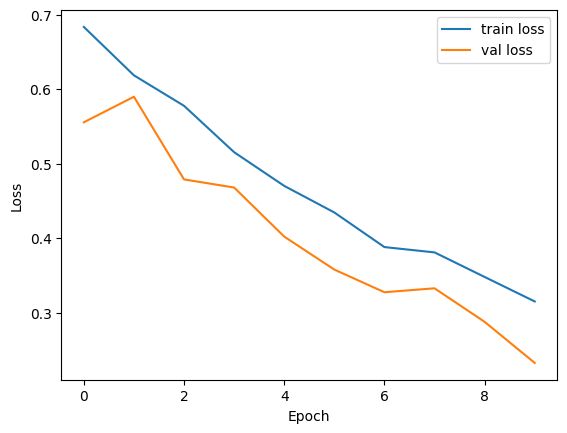

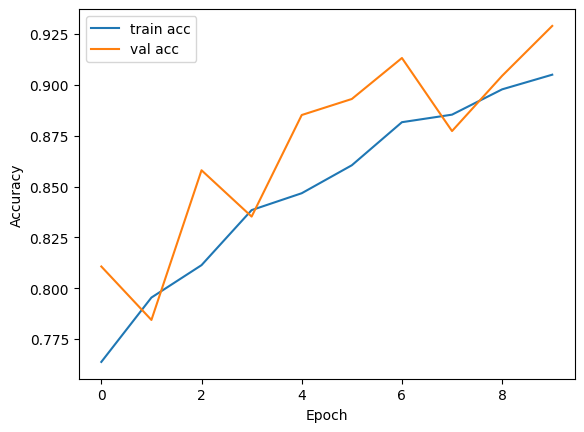

In [56]:
# Plot training & validation loss
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [57]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │     1,105,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,571,577 (13.62 MB)

 Trainable params: 1,190,525 (4.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,381,052 (9.08 MB)

In [84]:
seq = text_to_sequence("Project Gallery")
xseq = pad_sequence(seq, MAX_SEQ_LEN)
print(xseq.shape)

(200,)


In [85]:
print(np.array([xseq]))
model.predict(np.array([xseq]))
# ['company overview', 'company services', 'client review', 'other', 'contact info']

[[  24 1516    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

array([[0.05103038, 0.06844172, 0.17753693, 0.56083524, 0.14215565]],
      dtype=float32)

In [87]:
model.save(str('../models/textzap.keras'))